In [74]:

import numpy,scipy,scipy.ndimage,zlib,pylab
from pylab import imread,imshow,savefig
from scipy import linalg,ndimage
from scipy.ndimage import interpolation,filters,morphology,measurements,fourier
from scipy.linalg import norm
from scipy.fftpack import fft,ifft,fft2,ifft2
figsize(8,8)

# Sample Data for Line Finding

We're going to illustrate the Hough transform for the problem of finding lines in a collection of points.

Hough transforms can also be used for more general object recognition problems (see below).

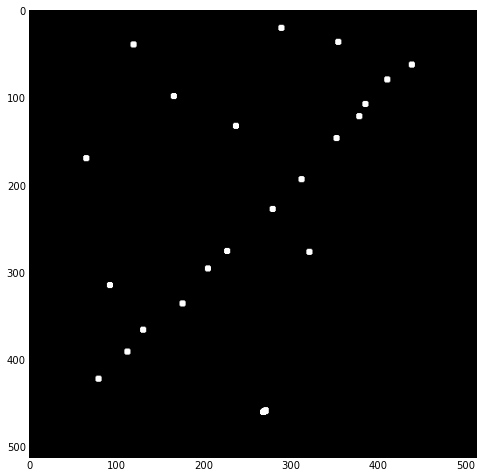

In [75]:
imshow(imread("points.png"))

In [76]:
image = transpose(imread("points.png")[::-1,:,0])
labels,n = measurements.label(image)
points = array(measurements.center_of_mass(image,labels,range(1,n)))

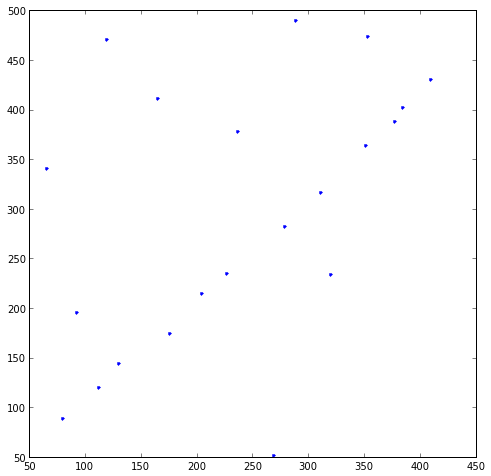

In [77]:
plot(points[:,0],points[:,1],'.')

# Hough Transform for Lines

The original Hough transform used the following parameterization:

$$ y = mx + b $$

The set of parameters corresponding to a point (x,y) is therefore:

$$ m = \frac{y-b}{x} $$

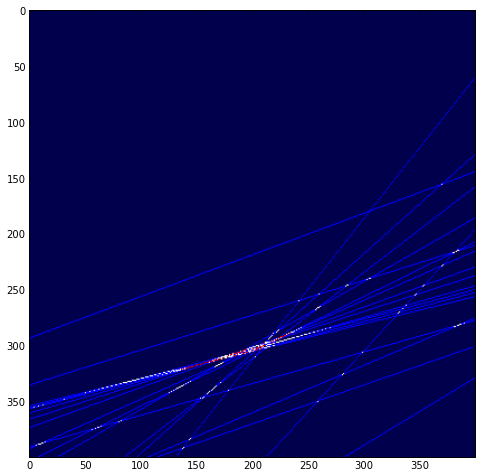

In [78]:
# Hough space in high resolution
N = 400; accumulator = zeros((N,N))
x,y = points[:,0],points[:,1]
for b in range(-200,200):
    m = (y-b)/x
    bi = int(b+200)    
    for mi in array((m+2)*100.0,'i'):
        if bi<0 or bi>=N or mi<0 or mi>=N: continue
        accumulator[mi,bi] += 1
imshow(accumulator,cmap=cm.seismic)

Coarse buckets:

The traditional Hough transform uses "bins" or "buckets" for accumulation. That's similar to downsampling after a box filtering operation.



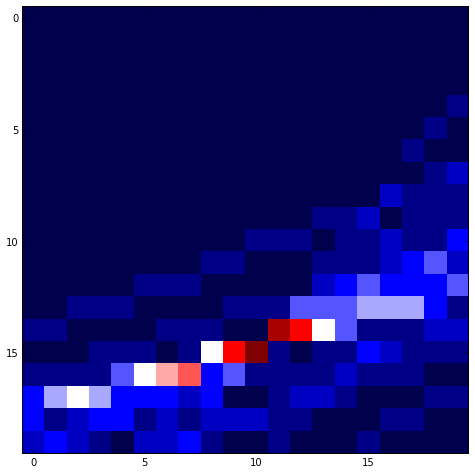

In [79]:
N = 20
hough = zeros((N,N))
x,y = points[:,0],points[:,1]
for bi in range(20):
    b = (bi-10)*20.0
    m = (y-b)/x    
    for mi in array((m+2)*5.0,'i'):
        if bi<0 or bi>=N or mi<0 or mi>=N: continue
        hough[mi,bi] += 1
imshow(hough,cmap=cm.seismic,interpolation='nearest')

Probabilistic Hough Transform:

Bucketing is not a very good method for detecting maxima. 

It's better to accumulate at a high resolution, convolve with a
Gaussian, and then look for the maximum. 

That is a technique similar to something called the probabilistic
Hough tranform. 

However, a uniform Gaussian convolution is still not entirely justified; the actual convolution
needed for a correct probabilistic treatment would have to be spatially non-uniform.

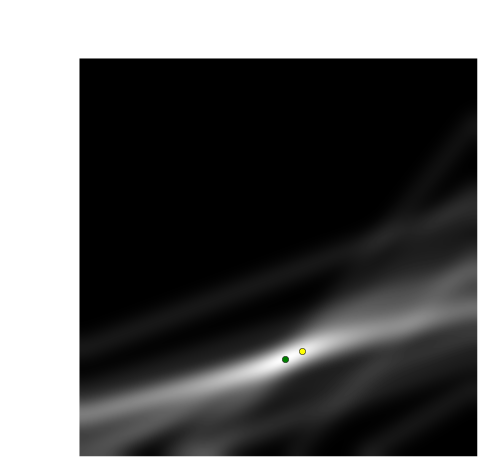

In [80]:
smoothed = filters.gaussian_filter(accumulator,10.0)
axis("off"); imshow(smoothed,cmap=cm.gray)
mi0,bi0 = measurements.maximum_position(accumulator); plot([bi0],[mi0],'o',color='yellow')
mi,bi = measurements.maximum_position(smoothed); plot([bi],[mi],'o',color='green')

To identify the actual line, we need to find the bucket containing the maximum and transform back.



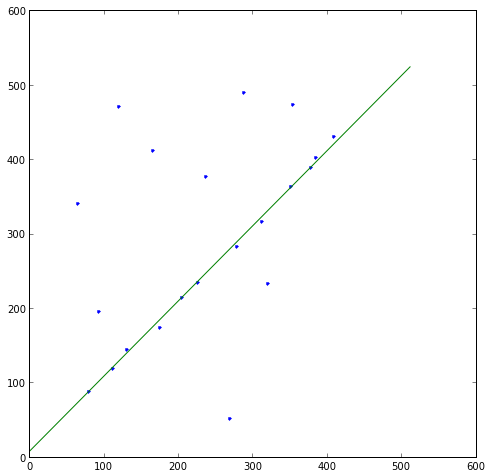

In [81]:
m = (mi-200)/100.0; b = bi-200.0
plot(points[:,0],points[:,1],'.'); plot([0,512],[b,m*512+b])

# Other Parameterization

The $ y = m x + b $ parameterization is not very good because we can't detect vertical lines.

It is better to parameterize lines by $\phi$ and $d$:

$$ x \cos \phi + y \sin \phi = d $$

$$ y = \frac{d}{\sin \phi} - x \frac{\cos \phi}{\sin \phi} $$

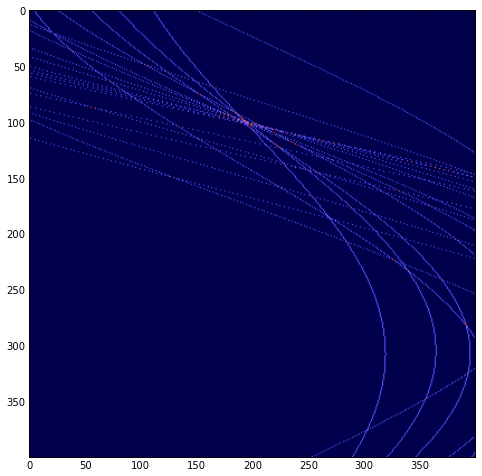

In [82]:
accumulator = zeros((400,400))
for x,y in points:
    for p in range(-200,200):
        phi = (pi/2)*p/200.0
        d = x*cos(phi)+y*sin(phi)
        if d<-200 or d>=200: continue
        accumulator[p+200,d+200] += 1
imshow(accumulator,cmap=cm.seismic)

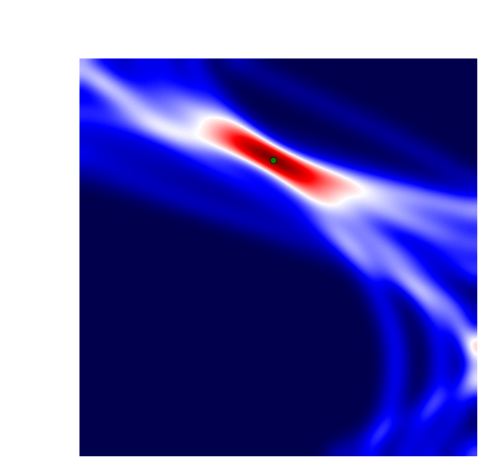

In [83]:
smoothed = filters.gaussian_filter(accumulator,10.0)
axis("off"); imshow(smoothed,cmap=cm.seismic)
p,di = measurements.maximum_position(smoothed)
plot([di],[p],'go')

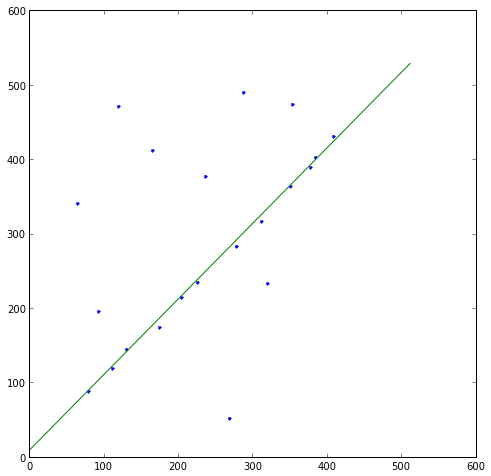

In [84]:
phi = (pi/2)*(p-200)/200.0
d = di-200
plot(points[:,0],points[:,1],'.')
plot([0,512],[d/sin(phi),d/sin(phi)-512*cos(phi)/sin(phi)],'g-')